# 残差块

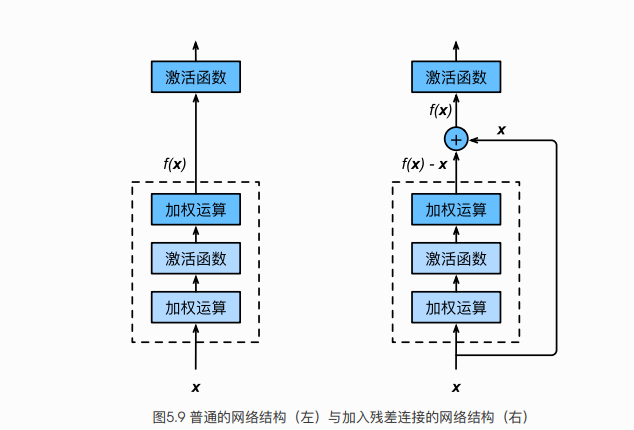

在残差块中，输⼊可通过跨层的数据线路更快地向前传播。
ResNet沿⽤了VGG全3x3 卷积层的设计。残差块⾥⾸先有2个有相同输出通道数的 3x3卷积层。每个卷积层后接⼀个批量归⼀化层和ReLU激活函数。然后我们将输⼊跳过这两个卷积运算后直接加在最后的ReLU激活函数前。这样的设计要求两个卷积层的输出与输⼊形状⼀样，从⽽可以相加。如果想改变通道数，就需要引⼊⼀个额外的1x1 卷积层来将输⼊变换成需要的形状后再做相加运算。

In [1]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import sys
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Residual(nn.Module):
    def __init__(self,in_channels,out_channels,use_1x1conv=False,stride=1):
        super(Residual,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else:
            self.conv3=None
        self.b1=nn.BatchNorm2d(out_channels)
        self.b2=nn.BatchNorm2d(out_channels)
    def forward(self,x):
        Y=F.relu(self.b1(self.conv1(x)))
        Y=self.b2(self.conv2(Y))
        if self.conv3:
            x=self.conv3(x)
        return F.relu(Y+x)

In [4]:
blk=Residual(3,3)
X=torch.rand((4,3,6,6))
blk(X).shape

torch.Size([4, 3, 6, 6])

In [5]:
blk=Residual(3,6,use_1x1conv=True,stride=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

# RESNET模型

ResNet的前两层跟之前介绍的GoogLeNet中的⼀样：在输出通道数为64、步幅为2的7x7 卷积层后接步幅为2的3x3 的最⼤池化层。不同之处在于ResNet每个卷积层后增加的批量归⼀化层。

In [2]:
net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

GoogLeNet在后⾯接了4个由Inception块组成的模块。ResNet则使⽤4个由残差块组成的模块，每个模块使⽤若⼲个同样输出通道数的残差块。第⼀个模块的通道数同输⼊通道数⼀致。由于之前已经使⽤了步幅为2的最⼤池化层，所以⽆须减⼩⾼和宽。之后的每个模块在第⼀个残差块⾥将上⼀个模块的通道数翻倍，并将⾼和宽减半。

In [3]:
def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
    if first_block:
        assert in_channels==out_channels # 第⼀个模块的通道数同输⼊通道数⼀致
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(in_channels,out_channels,use_1x1conv=True,stride=2))
        else:
            blk.append(Residual(out_channels,out_channels))
    return nn.Sequential(*blk)

In [4]:
net.add_module('resnet_block1',resnet_block(64,64,2,first_block=True))
net.add_module('resnet_block2',resnet_block(64,128,2))
net.add_module('resnet_block3',resnet_block(128,256,2))
net.add_module('resnet_block4',resnet_block(256,512,2))

In [5]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])

In [6]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [7]:
net.add_module('global_avg_pool',GlobalAvgPool2d()) #GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module('fc',nn.Sequential(FlattenLayer(),nn.Linear(512,10)))

这⾥每个模块⾥有4个卷积层（不计算1x1 卷积层），加上最开始的卷积层和最后的全连接层，共计18层。这个模型通常也被称为ResNet-18。通过配置不同的通道数和模块⾥的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。虽然ResNet的主体架构跟GoogLeNet的类似，但ResNet结构更简单，修改也更⽅便。这些因素都导致了ResNet迅速被⼴泛使⽤。

In [13]:
X=torch.rand((1,1,224,224))
for name,layer in net.named_children():
    X=layer(X)
    print(name,'output shape:',X.shape)

0 output shape: torch.Size([1, 64, 112, 112])
1 output shape: torch.Size([1, 64, 112, 112])
2 output shape: torch.Size([1, 64, 112, 112])
3 output shape: torch.Size([1, 64, 56, 56])
resnet_block1 output shape: torch.Size([1, 64, 56, 56])
resnet_block2 output shape: torch.Size([1, 128, 28, 28])
resnet_block3 output shape: torch.Size([1, 256, 14, 14])
resnet_block4 output shape: torch.Size([1, 512, 7, 7])
global_avg_pool output shape: torch.Size([1, 512, 1, 1])
fc output shape: torch.Size([1, 10])


# 获取数据和训练模型

In [8]:
import torchvision
import torchvision.transforms as transforms
def load_data_fashion_mnist(batch_size,resize=None,root='./Datasets/FashionMNIST'):
    trans=[]
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform=torchvision.transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root=root,train=True,download=True,transform=transform)
    mnist_test=torchvision.datasets.FashionMNIST(root=root,train=False,download=True,transform=transform)
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=0)
    return train_iter,test_iter

batch_size=256//2
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=96)
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)

In [9]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))
        

In [10]:
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda
epoch 1,loss 0.3853,train acc 0.859,test acc 0.889,time 562 sec
epoch 2,loss 0.1235,train acc 0.908,test acc 0.901,time 559 sec


KeyboardInterrupt: 